In [1]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.backbone.utils import FromBuffer , CutPSD, NormLayer
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
import pandas as pd 
import sqlite3
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
conn = sqlite3.connect(db_path)
# Read the 'meteo_data' table into a DataFrame
data_meteo = pd.read_sql('SELECT * FROM meteo_data', conn)
df_plot_meteo = data_meteo.pivot_table(index='date', columns='channel_name', values='value')
df_plot_meteo.index = pd.to_datetime(df_plot_meteo.index)
# Close the database connection
conn.close()

In [8]:
import numpy as np
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x','y']]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))]*len(columns)
query_key = f'''
    SELECT id FROM reshaped
    WHERE date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
'''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='reshaped', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=248, return_dict=True, cached=True,num_workers=16)


In [9]:
data_loader.setup()

In [10]:
for batch in data_loader.train_dataloader():
    break

In [12]:
batch

{'psd_level1_x': tensor([[0.6262, 0.5693, 0.4083,  ..., 0.4949, 0.4757, 0.4506],
         [0.6165, 0.5587, 0.2219,  ..., 0.2575, 0.2455, 0.2335],
         [0.6178, 0.5602, 0.3719,  ..., 0.2350, 0.2320, 0.2267],
         ...,
         [0.6354, 0.5777, 0.3041,  ..., 0.1137, 0.1249, 0.1294],
         [0.6166, 0.5593, 0.3097,  ..., 0.2515, 0.2491, 0.2459],
         [0.6191, 0.5615, 0.2888,  ..., 0.0548, 0.0803, 0.0728]]),
 'psd_level1_y': tensor([[0.5316, 0.4739, 0.3120,  ..., 0.5267, 0.5071, 0.4919],
         [0.5403, 0.4825, 0.2256,  ..., 0.2785, 0.2700, 0.2614],
         [0.5331, 0.4761, 0.3038,  ..., 0.2452, 0.2400, 0.2419],
         ...,
         [0.5179, 0.4609, 0.2829,  ..., 0.1380, 0.1358, 0.1249],
         [0.5339, 0.4772, 0.3243,  ..., 0.2801, 0.2802, 0.2774],
         [0.5509, 0.4930, 0.2534,  ..., 0.0558, 0.0768, 0.0641]]),
 'psd_level2_x': tensor([[0.6066, 0.5492, 0.3984,  ..., 0.5205, 0.5013, 0.4767],
         [0.5466, 0.4890, 0.2222,  ..., 0.2830, 0.2711, 0.2596],
         [

In [13]:
import torch
import torch.nn as nn
from hannover_pylon.modelling.backbone import utils as ut
import pytorch_lightning as pl

class OneToOneManyModelsAutoEncoder(nn.Module):
    def __init__(self, psd_length=1490, hidden_dims=[512, 128, 64], latent_dim=32, 
                 model_list=None):
        """
        An autoencoder model that maintains one separate autoencoder per sensor.
        
        Args:
            psd_length (int): Length of each PSD vector.
            hidden_dims (list): Hidden layer sizes for the encoder.
            latent_dim (int): Dimension of the latent space.
            model_list (list): List of sensor names. If None, defaults to:
                ['psd_level1_x', 'psd_level1_y', 'psd_level2_x', 'psd_level2_y', ..., 'psd_level9_y'].
        """
        super().__init__()
        if model_list is None:
            model_list = [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x', 'y']]
        self.model_list = model_list
        self.psd_length = psd_length
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.decoder_dims = hidden_dims[::-1]
        
        # Create separate modules for each sensor.
        self.encoder = nn.ModuleDict()
        self.latent_layer = nn.ModuleDict()
        self.decoder = nn.ModuleDict()
        
        for sensor in self.model_list:
            self.encoder[sensor] = ut.build_layers(
                hidden_dims=[psd_length] + hidden_dims,
                activation_list=['relu'] * len(hidden_dims),
                batch_norm=False,
            )
            self.latent_layer[sensor] = nn.Linear(hidden_dims[-1], latent_dim)
            self.decoder[sensor] = ut.build_layers(
                hidden_dims=[latent_dim] + self.decoder_dims + [psd_length],
                activation_list=['relu'] * (len(self.decoder_dims)) + ['sigmoid'],
                batch_norm=False,
            )
        self.device_ = None

    def forward(self, x_dict):
        """
        Args:
            x_dict (dict): Dictionary containing sensor data. For example:
                {
                  'psd_level1_x': tensor(...),
                  'psd_level1_y': tensor(...),
                  ... 
                }
        Returns:
            dict: A dictionary with the same sensor keys, where each value is a dict with:
                  - "reconstruction": the reconstructed PSD vector,
                  - "latent": the latent vector.
        """
        if self.device_ is None:
            self.device_ = next(self.parameters()).device
        
        outputs = {}
        for sensor in self.model_list:
            if sensor in x_dict:
                x = x_dict[sensor].to(self.device_)
                encoded = self.encoder[sensor](x)
                latent = self.latent_layer[sensor](encoded)
                reconstruction = self.decoder[sensor](latent)
                outputs[sensor] = {"reconstruction": reconstruction, "latent": latent}
        return outputs
    
class OneToOneManyModelsTrainingModule(pl.LightningModule):
    def __init__(self, psd_length=1490, hidden_dims=[512,128,64], latent_dim=32, 
                 lr=1e-3, model_list=None):
        """
        Lightning module to train one autoencoder per sensor.
        
        The loss is computed as the average MSE reconstruction loss across all sensors.
        """
        super().__init__()
        self.model = OneToOneManyModelsAutoEncoder(psd_length=psd_length, 
                                                   hidden_dims=hidden_dims, 
                                                   latent_dim=latent_dim,
                                                   model_list=model_list)
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.save_hyperparameters(ignore="model")
        
    def forward(self, batch):
        return self.model(batch)
    
    def training_step(self, batch, batch_idx):
        outputs = self(batch)  # dictionary of sensor outputs
        total_loss = 0.0
        sensor_count = 0
        for sensor, sensor_out in outputs.items():
            # Ensure the target is on the same device.
            target = batch[sensor].to(sensor_out["reconstruction"].device)
            loss_sensor = self.loss_fn(sensor_out["reconstruction"], target)
            total_loss += loss_sensor
            sensor_count += 1
        total_loss = total_loss / sensor_count if sensor_count > 0 else total_loss
        self.log("train_loss", total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch)
        total_loss = 0.0
        sensor_count = 0
        for sensor, sensor_out in outputs.items():
            target = batch[sensor].to(sensor_out["reconstruction"].device)
            loss_sensor = self.loss_fn(sensor_out["reconstruction"], target)
            total_loss += loss_sensor
            sensor_count += 1
        total_loss = total_loss / sensor_count if sensor_count > 0 else total_loss
        self.log("val_loss", total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [14]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

# Instantiate your Lightning module.
model = OneToOneManyModelsTrainingModule(
    psd_length=1490,
    hidden_dims=[512,256,128],
    latent_dim=4,
    lr=1e-3
)


# Define a model checkpoint callback to save the best models.
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',              # Monitor the validation loss.
    dirpath='checkpoints',           # Directory to save checkpoints.
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}', 
    save_top_k=3,                    # Save the 3 best models.
    mode='min'
)

# Define an early stopping callback (optional).
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Create the Trainer instance.
trainer = Trainer(
    max_epochs=150,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator='gpu'
)

# Start training.
trainer.fit(model,data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_

DataModule already setup


/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 29/29 [00:02<00:00, 14.07it/s, v_num=198, train_loss=0.0201, val_loss=0.0221]

Metric val_loss improved. New best score: 0.022


Epoch 1: 100%|██████████| 29/29 [00:02<00:00, 11.02it/s, v_num=198, train_loss=0.0111, val_loss=0.0108]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.011


Epoch 2: 100%|██████████| 29/29 [00:02<00:00, 10.82it/s, v_num=198, train_loss=0.00244, val_loss=0.00291]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.003


Epoch 3: 100%|██████████| 29/29 [00:02<00:00, 10.70it/s, v_num=198, train_loss=0.000835, val_loss=0.000866]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 29/29 [00:02<00:00, 10.72it/s, v_num=198, train_loss=0.000623, val_loss=0.000502]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 29/29 [00:02<00:00, 10.83it/s, v_num=198, train_loss=0.000376, val_loss=0.000459]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 6: 100%|██████████| 29/29 [00:02<00:00, 10.60it/s, v_num=198, train_loss=0.000389, val_loss=0.000432]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 7: 100%|██████████| 29/29 [00:02<00:00, 10.54it/s, v_num=198, train_loss=0.000489, val_loss=0.000415]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 8: 100%|██████████| 29/29 [00:02<00:00, 10.55it/s, v_num=198, train_loss=0.000293, val_loss=0.000398]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 9: 100%|██████████| 29/29 [00:02<00:00, 10.60it/s, v_num=198, train_loss=0.000371, val_loss=0.000389]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 10: 100%|██████████| 29/29 [00:02<00:00, 10.42it/s, v_num=198, train_loss=0.000342, val_loss=0.00037] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 11: 100%|██████████| 29/29 [00:02<00:00, 10.42it/s, v_num=198, train_loss=0.000378, val_loss=0.000362]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 12: 100%|██████████| 29/29 [00:02<00:00, 10.58it/s, v_num=198, train_loss=0.000299, val_loss=0.000358]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 13: 100%|██████████| 29/29 [00:02<00:00, 10.56it/s, v_num=198, train_loss=0.000425, val_loss=0.000355]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 15: 100%|██████████| 29/29 [00:02<00:00, 10.39it/s, v_num=198, train_loss=0.000542, val_loss=0.000348]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 29/29 [00:02<00:00, 10.46it/s, v_num=198, train_loss=0.000355, val_loss=0.000348]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 29/29 [00:02<00:00, 10.52it/s, v_num=198, train_loss=0.000404, val_loss=0.000336]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 29/29 [00:02<00:00, 10.43it/s, v_num=198, train_loss=0.000276, val_loss=0.000326]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 29/29 [00:02<00:00, 10.38it/s, v_num=198, train_loss=0.000338, val_loss=0.000322]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 29/29 [00:02<00:00, 10.38it/s, v_num=198, train_loss=0.000259, val_loss=0.00032] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 29/29 [00:02<00:00, 10.36it/s, v_num=198, train_loss=0.000386, val_loss=0.00032] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 29/29 [00:02<00:00, 10.48it/s, v_num=198, train_loss=0.000283, val_loss=0.000311]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 29/29 [00:02<00:00, 10.55it/s, v_num=198, train_loss=0.00032, val_loss=0.000309] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 29/29 [00:02<00:00, 10.65it/s, v_num=198, train_loss=0.000324, val_loss=0.000307]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 29/29 [00:02<00:00, 10.50it/s, v_num=198, train_loss=0.00028, val_loss=0.000298] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 29/29 [00:02<00:00, 10.51it/s, v_num=198, train_loss=0.000274, val_loss=0.000296]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 29/29 [00:02<00:00, 10.57it/s, v_num=198, train_loss=0.000333, val_loss=0.000288]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 29/29 [00:02<00:00, 10.08it/s, v_num=198, train_loss=0.000281, val_loss=0.000283]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 29/29 [00:02<00:00, 10.51it/s, v_num=198, train_loss=0.000338, val_loss=0.000283]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 29/29 [00:02<00:00, 10.39it/s, v_num=198, train_loss=0.000254, val_loss=0.000278]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 29/29 [00:02<00:00, 10.54it/s, v_num=198, train_loss=0.0002, val_loss=0.000275]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 29/29 [00:02<00:00, 10.05it/s, v_num=198, train_loss=0.000245, val_loss=0.000272]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 29/29 [00:02<00:00, 10.15it/s, v_num=198, train_loss=0.000206, val_loss=0.000268]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 29/29 [00:02<00:00, 10.07it/s, v_num=198, train_loss=0.000321, val_loss=0.000266]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 29/29 [00:02<00:00, 10.47it/s, v_num=198, train_loss=0.000315, val_loss=0.000264]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 29/29 [00:02<00:00, 10.47it/s, v_num=198, train_loss=0.000233, val_loss=0.000262]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 29/29 [00:02<00:00, 10.30it/s, v_num=198, train_loss=0.000277, val_loss=0.000258]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 49: 100%|██████████| 29/29 [00:02<00:00, 10.45it/s, v_num=198, train_loss=0.000259, val_loss=0.000254]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 53: 100%|██████████| 29/29 [00:02<00:00, 10.43it/s, v_num=198, train_loss=0.000293, val_loss=0.000251]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 54: 100%|██████████| 29/29 [00:02<00:00, 10.68it/s, v_num=198, train_loss=0.000218, val_loss=0.000249]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 29/29 [00:02<00:00, 10.51it/s, v_num=198, train_loss=0.000289, val_loss=0.000247]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 58: 100%|██████████| 29/29 [00:02<00:00, 10.23it/s, v_num=198, train_loss=0.000278, val_loss=0.000246]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 68: 100%|██████████| 29/29 [00:02<00:00, 10.29it/s, v_num=198, train_loss=0.000286, val_loss=0.000242]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 70: 100%|██████████| 29/29 [00:02<00:00, 10.38it/s, v_num=198, train_loss=0.000305, val_loss=0.000241]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 74: 100%|██████████| 29/29 [00:02<00:00, 10.30it/s, v_num=198, train_loss=0.000203, val_loss=0.000236]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 75: 100%|██████████| 29/29 [00:02<00:00, 10.12it/s, v_num=198, train_loss=0.000272, val_loss=0.000235]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 80: 100%|██████████| 29/29 [00:02<00:00, 10.28it/s, v_num=198, train_loss=0.000206, val_loss=0.000234]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 83: 100%|██████████| 29/29 [00:02<00:00, 10.41it/s, v_num=198, train_loss=0.000216, val_loss=0.000233]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 84: 100%|██████████| 29/29 [00:02<00:00, 10.24it/s, v_num=198, train_loss=0.000245, val_loss=0.000232]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 85: 100%|██████████| 29/29 [00:02<00:00, 10.25it/s, v_num=198, train_loss=0.000196, val_loss=0.000228]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 91: 100%|██████████| 29/29 [00:02<00:00, 10.25it/s, v_num=198, train_loss=0.000225, val_loss=0.000227]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 93: 100%|██████████| 29/29 [00:02<00:00, 10.23it/s, v_num=198, train_loss=0.000198, val_loss=0.000221]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 96: 100%|██████████| 29/29 [00:02<00:00, 10.14it/s, v_num=198, train_loss=0.000252, val_loss=0.000214]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 97: 100%|██████████| 29/29 [00:02<00:00, 10.33it/s, v_num=198, train_loss=0.000251, val_loss=0.000213]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 98: 100%|██████████| 29/29 [00:02<00:00, 10.24it/s, v_num=198, train_loss=0.000195, val_loss=0.00021] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 103: 100%|██████████| 29/29 [00:02<00:00, 10.14it/s, v_num=198, train_loss=0.000193, val_loss=0.000209]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 106: 100%|██████████| 29/29 [00:02<00:00, 10.27it/s, v_num=198, train_loss=0.0002, val_loss=0.000208]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 107: 100%|██████████| 29/29 [00:02<00:00, 10.40it/s, v_num=198, train_loss=0.000193, val_loss=0.000207]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 109: 100%|██████████| 29/29 [00:02<00:00, 10.21it/s, v_num=198, train_loss=0.000194, val_loss=0.000204]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 113: 100%|██████████| 29/29 [00:02<00:00, 10.27it/s, v_num=198, train_loss=0.000197, val_loss=0.000204]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 116: 100%|██████████| 29/29 [00:02<00:00, 10.34it/s, v_num=198, train_loss=0.000186, val_loss=0.000201]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 118: 100%|██████████| 29/29 [00:02<00:00, 10.31it/s, v_num=198, train_loss=0.000205, val_loss=0.0002]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 119: 100%|██████████| 29/29 [00:02<00:00, 10.27it/s, v_num=198, train_loss=0.000153, val_loss=0.0002]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 124: 100%|██████████| 29/29 [00:02<00:00, 10.25it/s, v_num=198, train_loss=0.000205, val_loss=0.000198]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 128: 100%|██████████| 29/29 [00:02<00:00, 10.11it/s, v_num=198, train_loss=0.000187, val_loss=0.000195]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 130: 100%|██████████| 29/29 [00:02<00:00, 10.43it/s, v_num=198, train_loss=0.000164, val_loss=0.000193]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 134: 100%|██████████| 29/29 [00:02<00:00, 10.36it/s, v_num=198, train_loss=0.000202, val_loss=0.000192]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 135: 100%|██████████| 29/29 [00:02<00:00, 10.32it/s, v_num=198, train_loss=0.000184, val_loss=0.000189]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 141: 100%|██████████| 29/29 [00:02<00:00, 10.16it/s, v_num=198, train_loss=0.000184, val_loss=0.000187]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 146: 100%|██████████| 29/29 [00:02<00:00, 10.23it/s, v_num=198, train_loss=0.000168, val_loss=0.000185]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 147: 100%|██████████| 29/29 [00:02<00:00, 10.26it/s, v_num=198, train_loss=0.000134, val_loss=0.000184]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 149: 100%|██████████| 29/29 [00:02<00:00, 10.11it/s, v_num=198, train_loss=0.000234, val_loss=0.000193]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 29/29 [00:02<00:00, 10.10it/s, v_num=198, train_loss=0.000234, val_loss=0.000193]


In [15]:
best_model_path = checkpoint_callback.best_model_path
# print mse loss
print(checkpoint_callback.best_model_score.item())
best_model = OneToOneManyModelsTrainingModule.load_from_checkpoint(best_model_path)

0.00018370362522546202


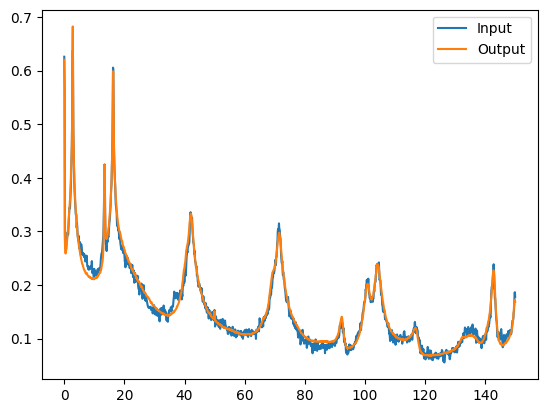

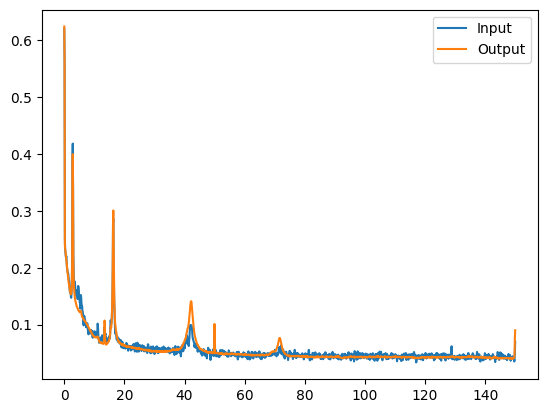

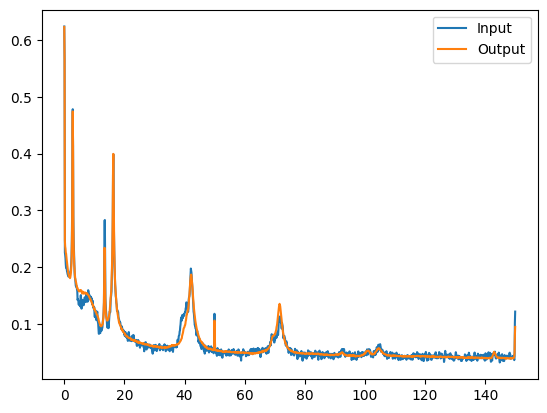

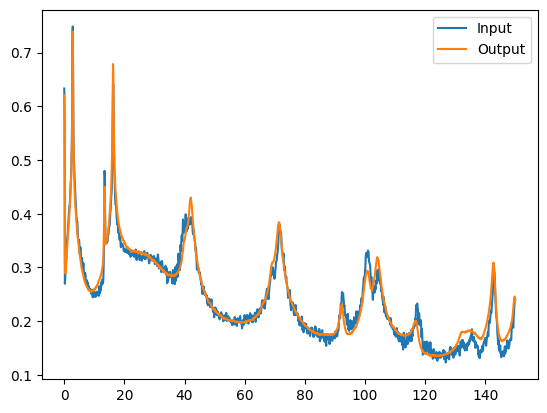

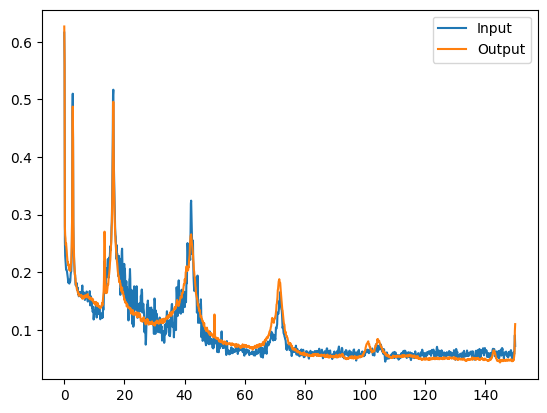

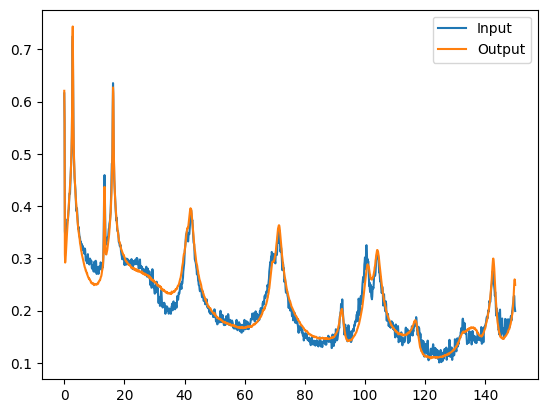

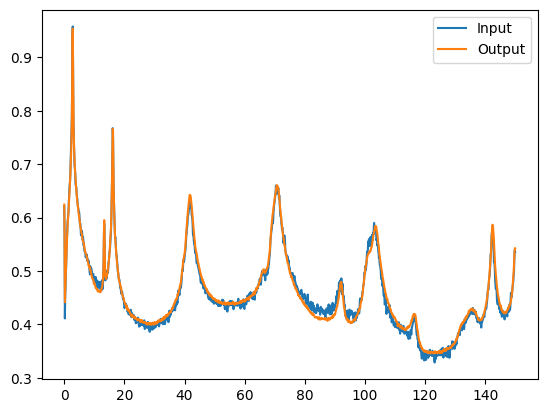

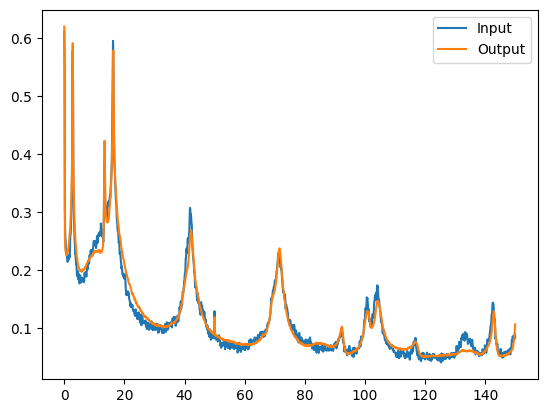

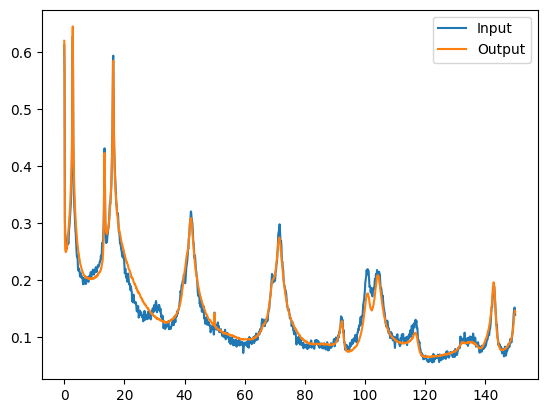

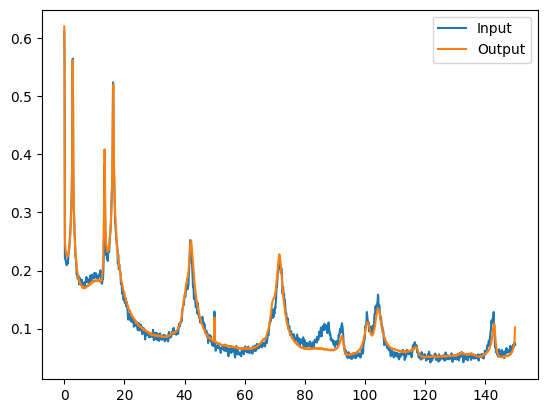

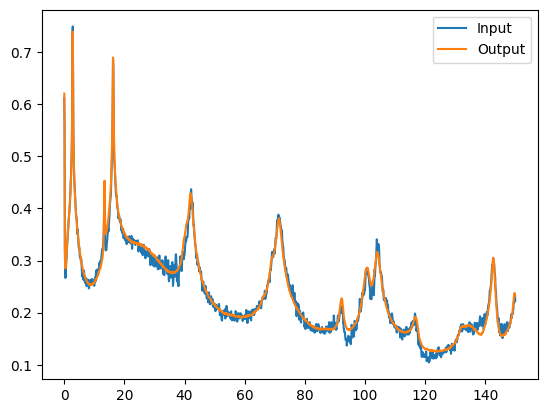

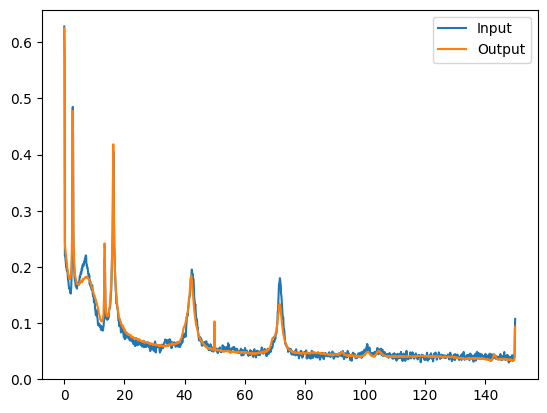

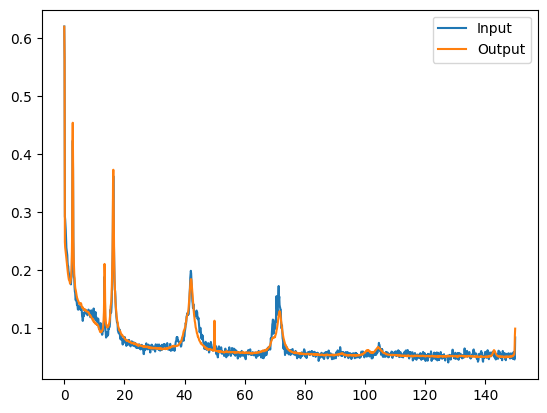

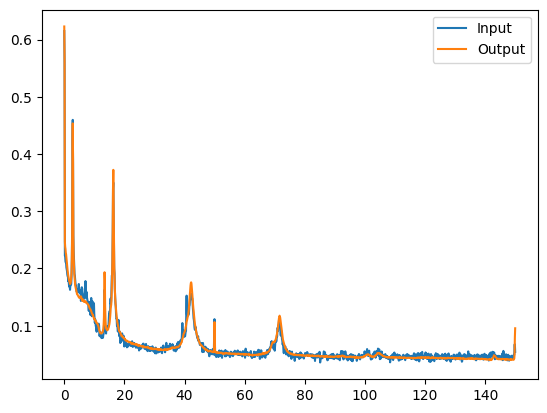

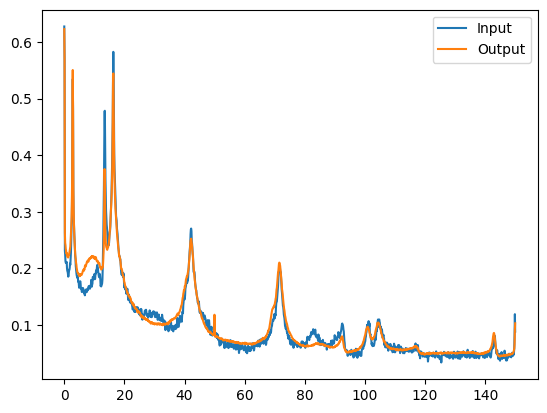

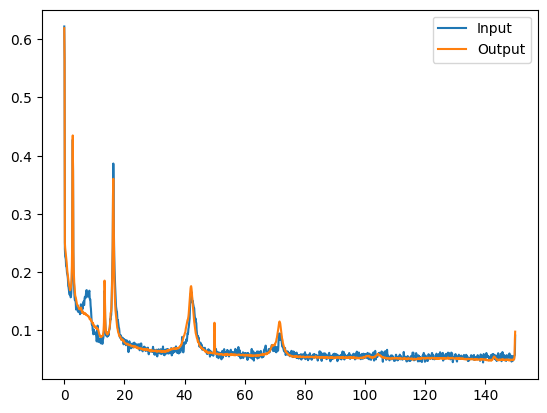

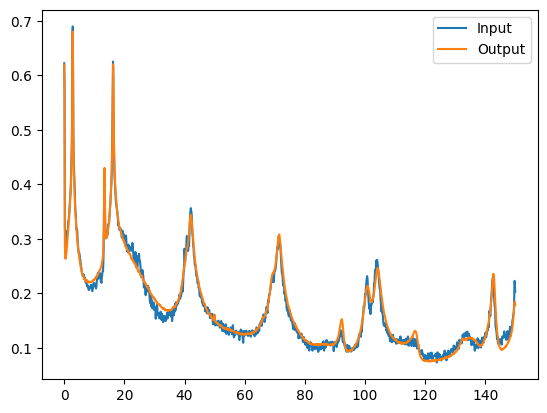

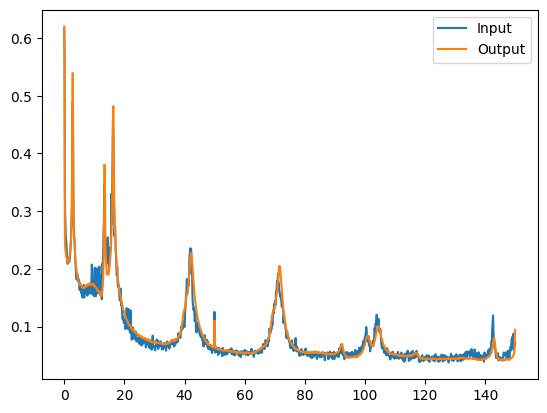

In [19]:
best_model.eval()
batch = next(iter(data_loader.val_dataloader()))
psd_out = best_model(batch)
psd_in = batch['psd_level1_x']
psd_out = psd_out['psd_level1_x']['reconstruction']                                 

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:1490], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:1490], psd_out[i].cpu().detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [20]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = next(model.parameters()).device

    def mse(self, x_dict):
        """
        Compute the 90th percentile squared error for each sensor and return
        the average error across all sensors.
        
        Args:
            x_dict (dict): Dictionary where keys are sensor names (e.g., "psd_level1_x")
                           and values are tensors of shape (B, psd_length).
        Returns:
            Tensor: Aggregated anomaly score for each sample (shape: (B,))
        """
        errors = {}
        with torch.no_grad():
            outputs = self.model(x_dict)  # outputs is a dict: { sensor_name: {"reconstruction": ..., "latent": ...}, ... }
        
        # Iterate over each sensor in the output.
        for sensor, out in outputs.items():
            # Get the corresponding input tensor and ensure it's on the correct device.
            x = x_dict[sensor].to(self.device)
            x_hat = out["reconstruction"]
            # Compute element-wise squared error.
            error = (x - x_hat) ** 2
            # Compute the 90th percentile error along the feature dimension (dim=1)
            quantile_error = torch.quantile(error, q=0.9, dim=1)  # shape: (B,)
            errors[sensor] = quantile_error
        
        # Aggregate the error across sensors (here we take the mean error per sample).
        all_errors = torch.stack(list(errors.values()), dim=1)  # shape: (B, num_sensors)
        aggregated_error = all_errors.mean(dim=1)
        return aggregated_error

    def forward(self, x_dict):
        return self.mse(x_dict)


In [21]:
best_model
detector = Detector(best_model)

# Get a batch from your data loader (which yields a dict with key "psd").
batch = next(iter(data_loader.val_dataloader()))

# Compute the damage metric for this batch.
damage_metric = detector(batch)  # returns a tensor of shape (B,)

print("Damage metric (90th percentile reconstruction error) per sample:")
print(damage_metric)

Damage metric (90th percentile reconstruction error) per sample:
tensor([3.5587e-04, 6.7538e-05, 1.0330e-04, 5.8173e-04, 5.6115e-04, 9.8384e-04,
        3.1572e-04, 4.1529e-04, 4.5134e-04, 2.9787e-04, 3.3700e-04, 1.6591e-04,
        1.6626e-04, 8.4499e-05, 3.0227e-04, 1.5583e-04, 3.4811e-04, 5.1837e-04,
        2.4450e-04, 4.2639e-04, 3.9856e-04, 5.9651e-04, 4.2965e-04, 4.3258e-04,
        3.1560e-04, 3.2181e-04, 3.2335e-04, 2.1600e-04, 2.9180e-04, 3.3083e-04,
        2.3112e-04, 3.9751e-04, 1.3606e-04, 2.2874e-04, 5.5977e-04, 8.6148e-04,
        4.0376e-04, 5.9318e-04, 1.9584e-04, 5.1986e-04, 5.4649e-04, 1.8857e-04,
        3.8958e-04, 3.3744e-04, 6.6393e-05, 2.4618e-04, 1.2210e-04, 2.1962e-04,
        4.5844e-04, 7.1332e-05, 4.1570e-04, 3.8264e-04, 9.6609e-05, 4.7367e-04,
        5.2806e-04, 4.5042e-04, 5.3975e-04, 8.9553e-04, 5.7593e-04, 3.9694e-04,
        1.1240e-04, 5.2404e-04, 1.2216e-04, 3.9862e-04, 6.4107e-04, 4.3136e-04,
        5.9431e-04, 1.1114e-03, 1.2020e-04, 3.8476e-04,

In [27]:
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns=['date']+ [f'psd_level{i+1}_{d}' for i in range(9) for d in ['x','y']]
transform_func = [nn.Identity()]+[nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(min_val=-5.46,max_val=4.96))]*len(columns) 
query_key = f'''
    SELECT id FROM reshaped
   '''
data_loader = dm.PSDDataModule(db_path= db_path,table_name='reshaped', columns=columns,transform_func=transform_func, query_key=query_key, batch_size=248, return_dict=True, cached=False,num_workers=16) 
data_loader.setup()


In [ ]:
import re
import pandas as pd

def extract_sensor_info(sensor_key):
    """
    Given a sensor key of the form 'psd_levelX_D', where X is a number and D is a direction,
    return the sensor name (i.e. X as a string) and the direction (e.g. 'x' or 'y').
    """
    pattern = r"^psd_level(\d+)_(\w)$"
    m = re.match(pattern, sensor_key)
    if m:
        sensor_name = m.group(1)  # only the digits, e.g. '1'
        direction = m.group(2)
        return sensor_name, direction
    return None, None

In [29]:
import torch
import numpy as np
import pandas as pd

df_list = []
# Iterate over all batches from the data loader.
for batch in data_loader.all_dataloader():
    # Get the common 'date' field.
    dates = batch["date"]
    if isinstance(dates, torch.Tensor):
        dates = dates.cpu().numpy()
    
    # For each sensor key in the batch (skip 'date' and any other non-sensor keys)
    for key in batch:
        if key == "date":
            continue
        # Get the input for this sensor.
        x = batch[key]
        # Compute the sensor's reconstruction error using the model.
        with torch.no_grad():
            # Note: detector.model returns a dictionary with sensor keys.
            sensor_out = detector.model({key: x})[key]
        x_hat = sensor_out["reconstruction"]
        # Compute element-wise squared error and then the 90th percentile along the feature dimension.
        error = (x.to(detector.device) - x_hat) ** 2
        quantile_error = torch.quantile(error, q=0.9, dim=1)  # shape: (B,)
        quantile_error_np = quantile_error.cpu().numpy()
        
        # Extract sensor information.
        sensor_name, direction = extract_sensor_info(key)
        
        # Build a DataFrame for this sensor.
        df_temp = pd.DataFrame({
            "date": dates,
            "mse": quantile_error_np,
            "sensor": key,
            "level": sensor_name,
            "direction": direction
        })
        df_list.append(df_temp)

# Concatenate all batch DataFrames.
df_res = pd.concat(df_list, ignore_index=True)
print(df_res.head())


                  date  anomaly_score        sensor sensor_name direction
0  2020-08-01 00:02:00       0.000144  psd_level1_x  psd_level1         x
1  2020-08-01 00:12:00       0.000156  psd_level1_x  psd_level1         x
2  2020-08-01 00:22:00       0.000302  psd_level1_x  psd_level1         x
3  2020-08-01 00:32:00       0.000269  psd_level1_x  psd_level1         x
4  2020-08-01 00:42:00       0.001475  psd_level1_x  psd_level1         x


In [31]:
import pandas as pd

# Convert the date column to datetime.
df_res['date'] = pd.to_datetime(df_res['date'])

# Define training period boundaries using your settings.
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end   = pd.to_datetime(settings.state.healthy_train.end)

def normalize_sensor(group):
    """
    For a given sensor group, normalize the 'mse' column using the training period's min and max.
    """
    # Create a mask for rows within the training period.
    train_mask = (group['date'] >= train_start) & (group['date'] <= train_end)
    
    if train_mask.any():
        train_min = group.loc[train_mask, 'anomaly_score'].quantile(0.01)
        train_max = group.loc[train_mask, 'anomaly_score'].quantile(0.98)
        if train_max - train_min != 0:
            group['anomaly_score'] = (group['anomaly_score'] - train_min) / (train_max - train_min)
        else:
            group['anomaly_score'] = 0.0  # Avoid division by zero.
    else:
        # If no training data is available for this sensor group, you can decide to leave it as is or set to NaN.
        group['anomaly_score'] = group['anomaly_score']  # or: group['mse'] = np.nan
    return group

# Group the DataFrame by sensor. Here, we assume that 'direction' indicates the sensor.
df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)

# Display the first few rows of the normalized DataFrame.
print(df_normalized.head())


                 date  anomaly_score        sensor sensor_name direction
0 2020-08-01 00:02:00       0.058614  psd_level1_x  psd_level1         x
1 2020-08-01 00:12:00       0.065723  psd_level1_x  psd_level1         x
2 2020-08-01 00:22:00       0.153120  psd_level1_x  psd_level1         x
3 2020-08-01 00:32:00       0.133450  psd_level1_x  psd_level1         x
4 2020-08-01 00:42:00       0.859082  psd_level1_x  psd_level1         x


/tmp/ipykernel_78400/2981297167.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = df_res.groupby('direction', group_keys=False).apply(normalize_sensor)


In [32]:
df_normalized['anomaly_score'].quantile(0.9)

np.float64(4.354096126556396)

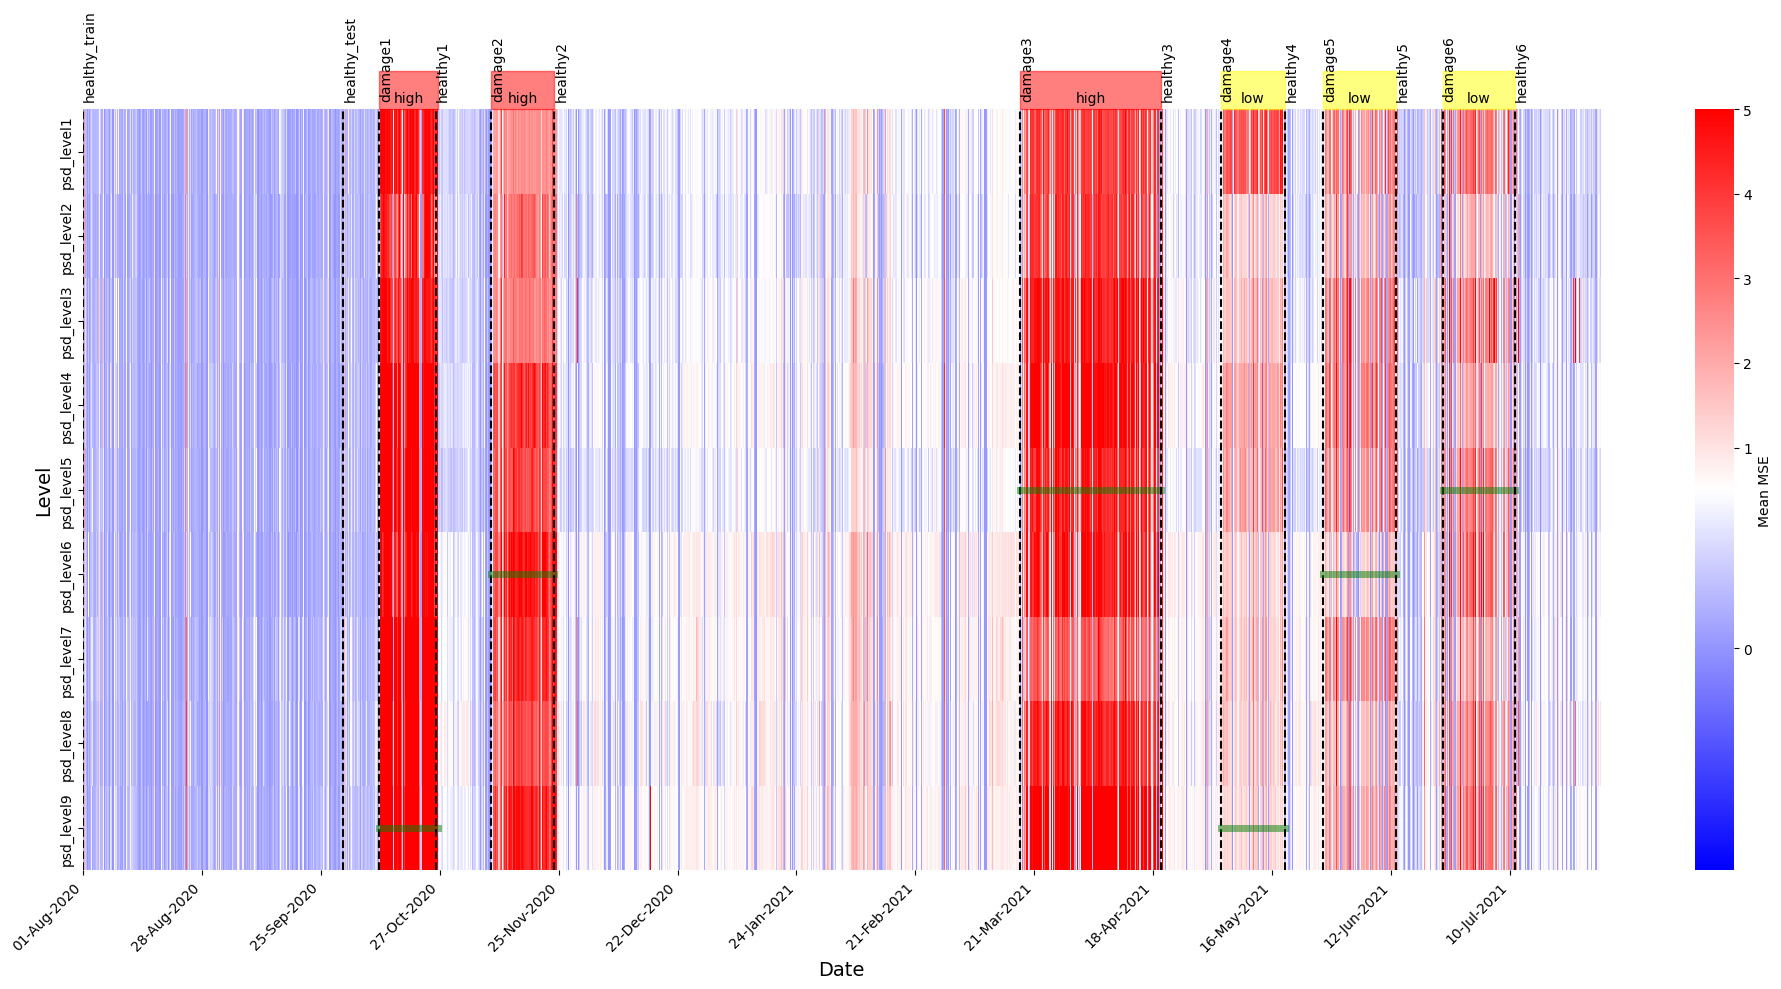

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
col_of_interest = 'anomaly_score'

# Ensure the date column is in datetime format.
df_normalized['date'] = pd.to_datetime(df_normalized['date'])

# Optionally, select a single sensor direction for the control chart.
# For instance, if you want to focus on the "y" direction:
df_control = df_normalized[df_normalized['direction'] == 'y']

# =============================================================================
# 2. Pivot the DataFrame for a Heatmap
# =============================================================================
# Create a pivot table with sensor level as the index, date as columns, and mean mse as values.
df_pivot = df_control.pivot_table(index='sensor_name', columns='date', values=col_of_interest, aggfunc='mean')
#df_pivot = df_pivot.rolling('1h').mean().T
# Ensure the pivot table's columns are datetime objects.
df_pivot.columns = pd.to_datetime(df_pivot.columns)

# =============================================================================
# 3. Create a Custom Date Formatter for the x-axis
# =============================================================================
def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        try:
            idx = int(x)
            if 0 <= idx < len(column_dates):
                return column_dates[idx].strftime('%d-%b-%Y')
            return ''
        except Exception:
            return ''
    return FuncFormatter(custom_date_format)

# =============================================================================
# 4. Define Custom Colormap and Norm
# =============================================================================
# Create a custom colormap from blue to white to red.
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_bwr', ['blue', 'white', 'red'])
# Use TwoSlopeNorm to center the colormap at 1, with vmin=0 and vmax=2.
norm = mcolors.TwoSlopeNorm(vmin=-0.7, vcenter=0.5, vmax=5)

# =============================================================================
# 5. Plot the Control Chart (Heatmap)
# =============================================================================
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    df_pivot,
    cmap=custom_cmap,                # Use the custom colormap.
    norm=norm,                       # Apply the normalization so that white is at 1.
    cbar_kws={'label': 'Mean MSE'},   # Label for the color bar.
    ax=ax
)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)

# Create a list of dates from the pivot table columns.
dates_list = list(df_pivot.columns)
ax.xaxis.set_major_formatter(create_date_formatter(dates_list))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Limit the number of x-axis ticks

# Rotate x-axis labels for better readability.
plt.xticks(rotation=45, ha='right')

# =============================================================================
# 6. (Optional) Annotate Events on the Chart
# =============================================================================
# If you have events defined in your settings, you can annotate the plot.
# For example, if events are stored as a dictionary in settings.state:
# events = {
#     "Event1": {"start": "2020-01-10", "end": "2020-01-12", "closest_sensor": 3, "severity": "high"},
#     "Event2": {"start": "2020-02-05", "end": "2020-02-07", "closest_sensor": 2, "severity": "low"}
# }
events = settings.state.to_dict()
for event_i, event_info in events.items():
    start = pd.to_datetime(event_info['start'])
    end = pd.to_datetime(event_info['end'])
    # Find approximate x-axis indices corresponding to start and end dates.
    idx_start = np.searchsorted(df_pivot.columns, start)
    idx_end = np.searchsorted(df_pivot.columns, end)
    
    # Draw a vertical line at the event start.
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw a horizontal line at the sensor level closest to the event (if provided).
    level = event_info.get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start/len(df_pivot.columns), xmax=idx_end/len(df_pivot.columns),
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a rectangle above the plot indicating severity.
    severity = event_info.get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        box_height = 0.05  # Height of the severity box.
        ax.add_patch(Rectangle(
            (idx_start, 1),       # Position above the plot.
            width=idx_end - idx_start,
            height=box_height,
            color=color,
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            clip_on=False
        ))
        ax.text((idx_start + idx_end) / 2, -0.1 + box_height, severity,
                ha='center', va='bottom', color='black')

# =============================================================================
# 7. Finalize and Show the Plot
# =============================================================================
plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.covariance import OAS

df_agg= df_normalized[df_normalized['direction']=="y"].pivot(index='date', columns='sensor', values='anomaly_score') 
df_agg.index = pd.to_datetime(df_agg.index)
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
train_mask = (df_agg.index >= train_start) & (df_agg.index <= train_end)
df_train = df_agg.loc[train_mask]
oas = OAS(store_precision=True, assume_centered=False)
oas.fit(df_train)
df_agg['mahal'] = np.sqrt(oas.mahalanobis(df_agg))

# --- 6. (Optional) Inspect the Results ---


In [40]:
negative_mask = df_plot_meteo['airTemperatureAt2m'] < 0

start_indices = df_plot_meteo.index[negative_mask & ~negative_mask.shift(fill_value=False)]
end_indices = df_plot_meteo.index[~negative_mask & negative_mask.shift(fill_value=False)]

# Ensure lengths match (handle open-ended cases)
if len(end_indices) < len(start_indices):
    end_indices = end_indices.append(pd.Index([df_plot_meteo.index[-1]]))

# Create a DataFrame with stardf_plot_meteot and end times of subzero temperature regions
date_subzero_temperature = pd.DataFrame({'start_time': start_indices, 'end_time': end_indices})


In [46]:
sensor_cols = df_agg.filter(regex=r'^psd_level\d+_y$').columns
df_agg['mean_mse'] = df_agg[sensor_cols].mean(axis=1)



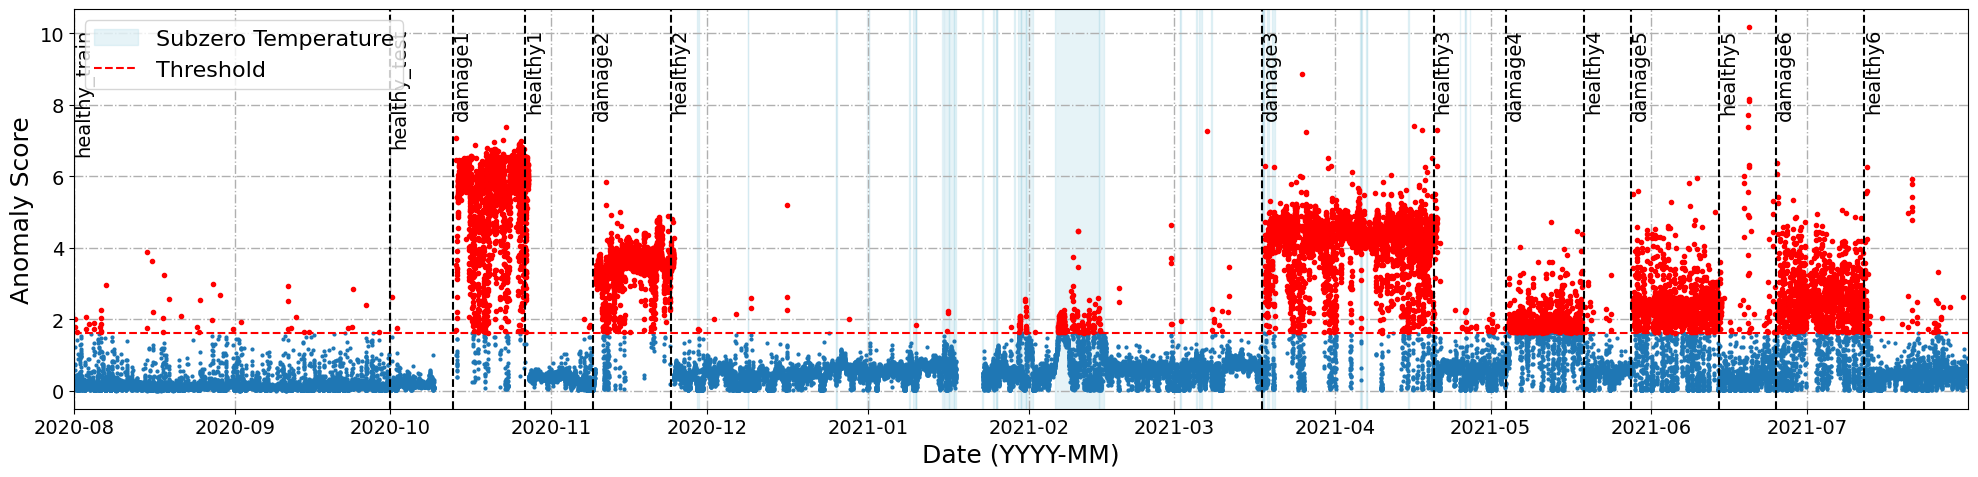

In [48]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------
# Update Publication Quality Settings with Increased Fonts
# ---------------------------
plt.rcParams.update({
    'font.size': 14,         # Base font size
    'axes.labelsize': 18,    # X and Y label font size
    'axes.titlesize': 20,    # Axes title font size
    'legend.fontsize': 16,   # Legend font size
    'xtick.labelsize': 14,   # X-tick label size
    'ytick.labelsize': 14,   # Y-tick label size
    'lines.linewidth': 1.5,
    'grid.linestyle': '-.',
    'grid.linewidth': 1,
})

# Define the column of interest (e.g., mean_mse).
col_of_interest = 'mean_mse'

# ---------------------------
# 1. Create Figure and Plot Main Control Chart
# ---------------------------
fig, ax = plt.subplots(figsize=(20, 5))

# Plot anomaly scores as individual points.
ax.plot(
    df_agg.index, 
    df_agg[col_of_interest],
    'o', 
    markersize=2, 
    color='tab:blue', 
)

# Compute threshold (99.5th percentile over the training period).
train_start = pd.to_datetime(settings.state.healthy_train.start)
train_end = pd.to_datetime(settings.state.healthy_train.end)
df_train = df_agg.loc[train_start:train_end]
threshold = df_train[col_of_interest].quantile(0.995)

# Plot the threshold as a horizontal dashed red line.
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')

# Highlight points exceeding the threshold.
exceed_mask = df_agg[col_of_interest] > threshold
ax.plot(
    df_agg.index[exceed_mask],
    df_agg.loc[exceed_mask, col_of_interest],
    'o', 
    markersize=3, 
    color='red',
)

# ---------------------------
# 2. Shade Subzero Temperature Regions
# ---------------------------
# Assume 'date_subzero_temperature' is a DataFrame with 'start_time' and 'end_time' columns.
for _, row in date_subzero_temperature.iterrows():
    ax.axvspan(
        row['start_time'], 
        row['end_time'], 
        color='lightblue', 
        alpha=0.3, 
        zorder=0
    )

# Create a patch for the legend.
subzero_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Subzero Temperature')

# ---------------------------
# 3. Add Legend and Annotate Events
# ---------------------------
# Combine existing legend handles with the subzero patch.
handles, labels = ax.get_legend_handles_labels()
handles.insert(0, subzero_patch)
labels.insert(0, 'Subzero Temperature')
ax.legend(handles, labels, loc='upper left', frameon=True)

# Annotate events from settings, if any.
for event_i, event_info in settings.state.to_dict().items():
    start = pd.to_datetime(event_info['start'])
    # Draw a vertical dashed line at the event start.
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    # Optionally, add text annotation near the top of the plot.
    ax.text(
        start, 
        ax.get_ylim()[1] * 0.95, 
        f'{event_i}', 
        rotation=90, 
        va='top', 
        ha='left'
    )

# ---------------------------
# 4. Final Touches
# ---------------------------
ax.set_xmargin(0)
ax.set_xlabel('Date (YYYY-MM)', fontsize=18)  # Increased label font size
ax.set_ylabel('Anomaly Score', fontsize=18)    # Increased label font size
ax.grid(True)

plt.tight_layout()

# Save the figure at high resolution (300 dpi) for journal publication.
plt.savefig("journal_plot.png", dpi=300)
plt.show()


In [49]:
df_plot_meteo.index = df_plot_meteo.index + pd.Timedelta(minutes=10)   
df_merge_temp = pd.merge_asof(df_agg,df_plot_meteo, 
                            left_index=True, right_index=True, direction='nearest')


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Example: Focus on level=1 data or a specific label. Adjust as needed.
# (If you already have df_res_level_meteo, skip re-assigning it.)
df_plot = df_merge_temp.copy()

# Drop rows missing MSE or Temperature.
df_plot = df_plot.dropna(subset=['mean_mse', 'airTemperatureAt2m'])


In [51]:
from hannover_pylon.utils.evaluation import label_dataframe_event 
df_plot['label']=label_dataframe_event(df_plot.index,events=settings.state.to_dict())
df_plot['label'].unique()

array(['healthy_train', 'healthy_test', 'damage1', 'healthy1', 'damage2',
       'healthy2', 'damage3', 'healthy3', 'damage4', 'healthy4',
       'damage5', 'healthy5', 'damage6', 'healthy6'], dtype=object)

/tmp/ipykernel_78400/1878487454.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_healthy_2.groupby('temp_bin')


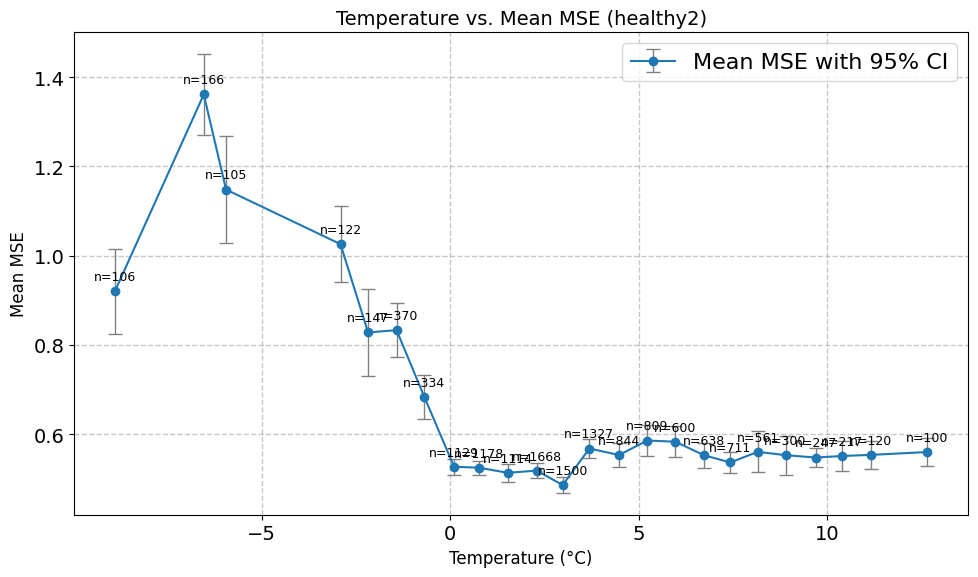

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t, pearsonr

# Assume df_plot is your merged DataFrame that contains:
# - 'airTemperatureAt2m': temperature readings,
# - 'mean_mse': the 2-hour rolling median of MSE (or your chosen aggregated anomaly score),
# - 'label': event/health label.

# Filter to the desired label (for example, "healthy2")
df_healthy_2 = df_plot[df_plot['label'] == 'healthy2'].copy()

# Create bins for temperature.
# Here we use 50 bins; adjust this number as needed.
df_healthy_2['temp_bin'] = pd.cut(df_healthy_2['airTemperatureAt2m'], bins=50)

# Group by these temperature bins.
grouped = df_healthy_2.groupby('temp_bin')

# Compute aggregated statistics per bin.
mean_temp = grouped['airTemperatureAt2m'].mean()        # Mean temperature in each bin
mean_mse = grouped['mean_mse'].mean()                     # Mean MSE in each bin
std_mse = grouped['mean_mse'].std()                       # Standard deviation of MSE
count_mse = grouped['mean_mse'].count()                   # Number of observations per bin

# Compute the standard error of the mean.
sem_mse = std_mse / np.sqrt(count_mse)

# Compute the t-critical value for a 95% confidence interval for each bin.
confidence_level = 0.95
# Degrees of freedom per bin
dof = count_mse - 1
dof[dof < 1] = np.nan  # Avoid errors for bins with too few samples
t_crit = t.ppf((1 + confidence_level) / 2, dof)

# Compute the margin of error.
margin_of_error = t_crit * sem_mse

# Filter out bins with fewer than 100 samples.
valid_bins = count_mse >= 100
mean_temp_valid = mean_temp[valid_bins]
mean_mse_valid = mean_mse[valid_bins]
margin_error_valid = margin_of_error[valid_bins]
count_valid = count_mse[valid_bins]

# Plot the binned data with error bars.
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(
    mean_temp_valid, 
    mean_mse_valid, 
    yerr=margin_error_valid,
    fmt='o-', capsize=5, ecolor='gray', elinewidth=1, markeredgewidth=1,
    label='Mean MSE with 95% CI'
)

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Mean MSE', fontsize=12)
ax.set_title('Temperature vs. Mean MSE (healthy2)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Annotate each point with the sample size.
for x, y, n in zip(mean_temp_valid, mean_mse_valid, count_valid):
    ax.annotate(f'n={int(n)}', xy=(x, y), xytext=(0, 8),
                textcoords='offset points', ha='center', fontsize=9)



plt.legend()
plt.tight_layout()
plt.show()


In [53]:
from evaluation_lumo.evaluation import compute_tr_by_events, compute_median_variation, prepare_dataframe
from hannover_pylon.modelling.finalexp.plot import display_damage_vs_healthy_table 
scores = compute_tr_by_events(df_agg.index,df_agg['mean_mse'])[0]
display_damage_vs_healthy_table(scores)
scores = compute_median_variation(df_agg.index,df_agg['mean_mse'])  
display_damage_vs_healthy_table(scores)


                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │       0.9442 │ healthy1             │        0.0033 │
│ damage2              │       0.9427 │ healthy2             │        0.0368 │
│ damage3              │       0.8782 │ healthy3             │        0.0243 │
│ damage4              │       0.7634 │ healthy4             │        0.0169 │
│ damage5              │       0.6510 │ healthy5             │        0.0462 │
│ damage6              │       0.6826 │ healthy6             │        0.0250 │
│                      │              │ healthy_test         │        0.0025 │
│                      │              │ healthy_train        │        0.0100 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

             Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Event                ┃  Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ no_event             │ 0.5426 │
└──────────────────────┴────────┘

                              Damage vs. Healthy                              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Damage Event         ┃ Damage Score ┃ Healthy Event        ┃ Healthy Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ damage1              │      36.8464 │ healthy1             │        2.2740 │
│ damage2              │      22.6257 │ healthy2             │        3.4830 │
│ damage3              │      27.5519 │ healthy3             │        3.7620 │
│ damage4              │      11.0004 │ healthy4             │        3.3983 │
│ damage5              │      12.9384 │ healthy5             │        2.3728 │
│ damage6              │      14.3565 │ healthy6             │        2.6441 │
│                      │              │ healthy_test         │        1.0674 │
│                      │              │ healthy_train        │        0.7536 │
└──────────────────────┴──────────────┴──────────────────────┴───────────────┘

              Others              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Event                ┃   Score ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ no_event             │ 12.0396 │
└──────────────────────┴─────────┘